## Adding labels to stored questions dataset

In [11]:
import pandas as pd

df1=pd.read_csv("SU_ParagID_Questions - Sheet1.csv")
df = pd.DataFrame(df1['QUESTION'])

# Define keywords for each category
categories = {
    'Campus': ['campus', 'hostel', 'building', 'facilities', 'library', 'cafeteria', 'parking', 'auditorium', 'wifi', 'gym', 'grounds'],
    'Admission': ['admission', 'apply', 'eligibility', 'fee', 'procedure', 'enrollment', 'deadline', 'form', 'application', 'quota'],
    'Faculty': ['faculty', 'professor', 'teacher', 'lecturer', 'staff', 'experience', 'department', 'teaching'],
    'Internship': ['internship', 'training', 'placement', 'project', 'opportunity', 'industry', 'career', 'practical'],
    'Curriculum': ['curriculum', 'syllabus', 'course', 'program', 'subjects', 'semester', 'credits', 'schedule', 'examination'],
    'Founder': ['founder', 'singhal', 'Amit Singhal']
}

# Function to assign category
def assign_category(question):
    question = question.lower()
    for category, keywords in categories.items():
        if any(keyword in question for keyword in keywords):
            return category
    return "Other"  # Default if no category matches

# Apply the function to the DataFrame
df['Category'] = df['QUESTION'].apply(assign_category)

# Save the labeled data to a CSV file
output_file = "labeled_questions.csv"
df.to_csv(output_file, index=False)

print(f"Labeled data saved to '{output_file}'")


Labeled data saved to 'labeled_questions.csv'


## categorising user questions by naive bayes algo and result analysis

Accuracy on test data: 0.80
Predictions saved to 'predicted_questions.csv'.


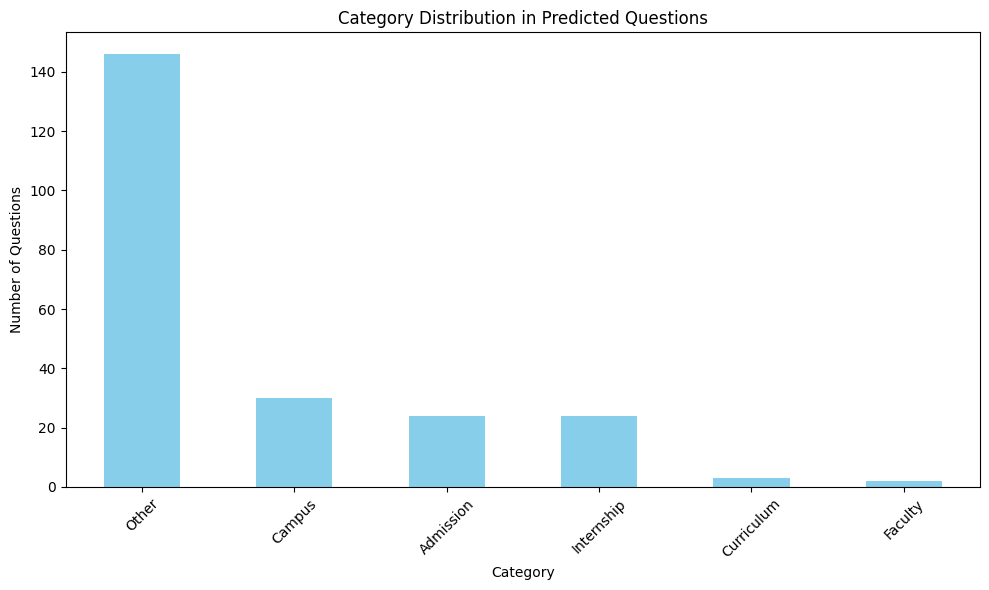

In [13]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Load the labeled data
labeled_df = pd.read_csv("labeled_questions.csv")  
new_questions_df = pd.read_csv("User Queries and feedback - Sheet1.csv")  

# Ensure the labeled dataset has columns 'Question' and 'Category'
if 'QUESTION' not in labeled_df.columns or 'Category' not in labeled_df.columns:
    raise ValueError("Labeled CSV must contain 'Question' and 'Category' columns.")
if 'Question' not in new_questions_df.columns:
    raise ValueError("New Questions CSV must contain a 'Question' column.")

# Preprocess data
X = labeled_df['QUESTION']
y = labeled_df['Category']

# Convert text to feature vectors
vectorizer = CountVectorizer(stop_words='english')
X_vectors = vectorizer.fit_transform(X)

# Split data for training and testing
X_train, X_test, y_train, y_test = train_test_split(X_vectors, y, test_size=0.2, random_state=42)

# Train a Naive Bayes classifier
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

# Test accuracy (optional, to verify the model's performance)
y_pred_test = nb_model.predict(X_test)
print(f"Accuracy on test data: {accuracy_score(y_test, y_pred_test):.2f}")

# Predict categories for the new questions
new_questions = new_questions_df['Question']
new_questions_vectors = vectorizer.transform(new_questions)
predicted_categories = nb_model.predict(new_questions_vectors)

# Add predictions to the new questions DataFrame
new_questions_df['Predicted_Category'] = predicted_categories

# Save the results to a new CSV file
new_questions_df.to_csv("predicted_questions.csv", index=False)
print("Predictions saved to 'predicted_questions.csv'.")

# Pictorial analysis: bar graph of category distribution
category_counts = new_questions_df['Predicted_Category'].value_counts()
plt.figure(figsize=(10, 6))
category_counts.plot(kind='bar', color='skyblue')
plt.title("Category Distribution in Predicted Questions")
plt.xlabel("Category")
plt.ylabel("Number of Questions")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## finding optimal K for k-means clustering on user questions

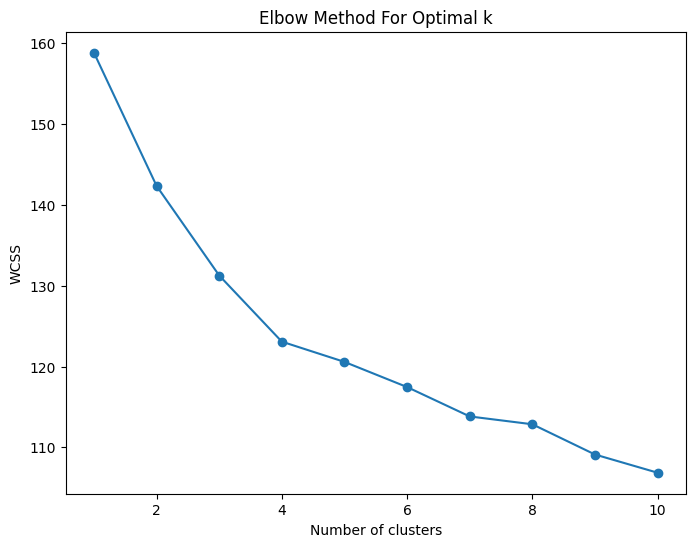

In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import psycopg2

# Database connection parameters
DB_PARAMS = {
    "dbname": "suchatbot",
    "user": "postgres",
    "password": "aks@sitare",
    "host": "localhost",
    "port": 5432
}

# Connect to the database
conn = psycopg2.connect(**DB_PARAMS)
cursor = conn.cursor()

# Fetch embeddings and questions from the database
cursor.execute("SELECT id, question, embedding FROM userquery")
data = cursor.fetchall()

# Close the connection
cursor.close()
conn.close()

# Convert data to DataFrame
df = pd.DataFrame(data, columns=["id", "question", "embedding"])
df["embedding"] = df["embedding"].apply(lambda x: np.array(eval(x)))

# Stack embeddings into a matrix
embeddings = np.vstack(df["embedding"].values)

# Elbow Method: Calculate WCSS (Within-Cluster Sum of Squares)
wcss = []
for k in range(1, 11):  # Testing with k=1 to k=10 clusters
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(embeddings)
    wcss.append(kmeans.inertia_)

# Plotting the Elbow Method
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

## Applying k-means clustering on user questions

Cluster counts:
 cluster
3    79
1    56
0    53
2    41
Name: count, dtype: int64


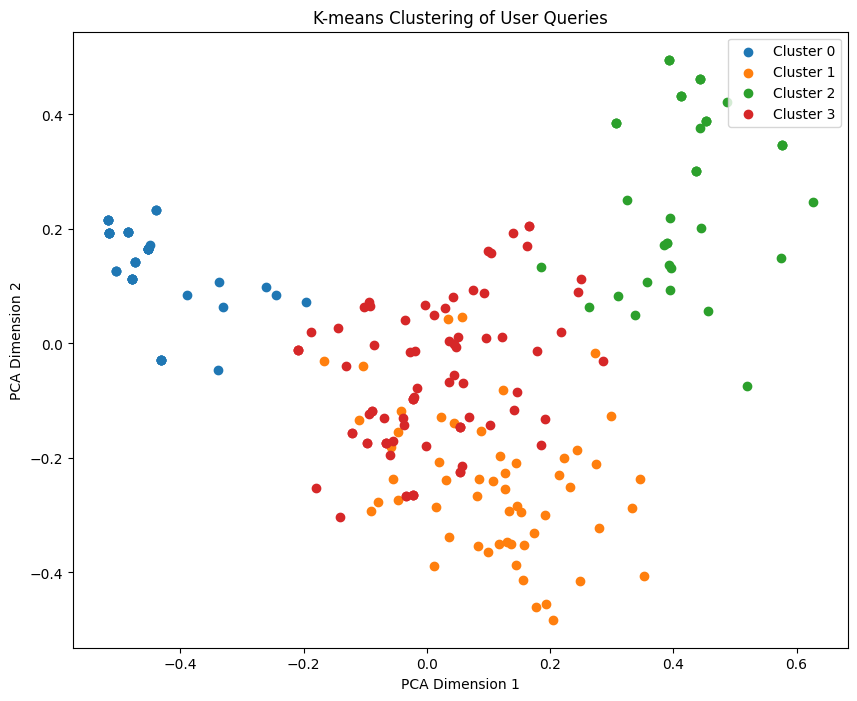


Cluster 0:
14    What is the university's policy on academic le...
20    What is the university's policy on academic pr...
26    What is the university's policy on academic di...
28    What is the university's policy on religious h...
31       What is the university's policy on attendance?
Name: question, dtype: object

Cluster 1:
0     What is the tuition fee for international stud...
3     What is the average class size for undergradua...
9       What are the job placement rates for graduates?
23    What is the process for transferring credits f...
38       How is the university's financial aid process?
Name: question, dtype: object

Cluster 2:
4     Are there any scholarship opportunities for in...
10    Are there any part-time job opportunities for ...
12    Are there any language courses available for i...
17         Are there any opportunities for internships?
24       Are there any study abroad programs available?
Name: question, dtype: object

Cluster 3:
1    What are the popu

In [16]:

# Apply K-means clustering
n_clusters = 4 # You can tune this value
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df["cluster"] = kmeans.fit_predict(embeddings)

# Analyze clusters
cluster_counts = df["cluster"].value_counts()
print("Cluster counts:\n", cluster_counts)

# Dimensionality reduction for visualization
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

# Add reduced dimensions to DataFrame
df["pca_x"] = reduced_embeddings[:, 0]
df["pca_y"] = reduced_embeddings[:, 1]

# Plot clusters
plt.figure(figsize=(10, 8))
for cluster in range(n_clusters):
    cluster_data = df[df["cluster"] == cluster]
    plt.scatter(cluster_data["pca_x"], cluster_data["pca_y"], label=f"Cluster {cluster}")

plt.title("K-means Clustering of User Queries")
plt.xlabel("PCA Dimension 1")
plt.ylabel("PCA Dimension 2")
plt.legend()
plt.show()

# Print out the questions in each cluster
for cluster in range(n_clusters):
    print(f"\nCluster {cluster}:")
    print(df[df["cluster"] == cluster]["question"].head(5))  # Display top 5 questions in each cluster

# Save the cluster results to a CSV file
df[["id", "question", "cluster"]].to_csv("clustered_questions.csv", index=False)


## finding optimal K for k-means clustering on stored dataset

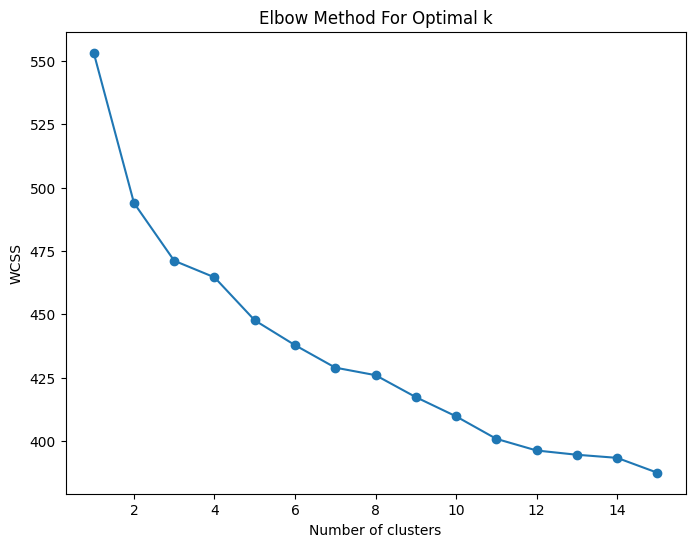

In [24]:

# Connect to the database
conn = psycopg2.connect(**DB_PARAMS)
cursor = conn.cursor()

# Fetch embeddings and questions from the database
cursor.execute("SELECT sr_no, question, embedding FROM questions")
data = cursor.fetchall()

# Close the connection
cursor.close()
conn.close()

# Convert data to DataFrame
df = pd.DataFrame(data, columns=["id", "question", "embedding"])
df["embedding"] = df["embedding"].apply(lambda x: np.array(eval(x)))

# Stack embeddings into a matrix
embeddings = np.vstack(df["embedding"].values)

# Elbow Method: Calculate WCSS (Within-Cluster Sum of Squares)
wcss = []
for k in range(1, 16):  # Testing with k=1 to k=10 clusters
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(embeddings)
    wcss.append(kmeans.inertia_)

# Plotting the Elbow Method
plt.figure(figsize=(8, 6))
plt.plot(range(1, 16), wcss, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

## applying k-means clustering on stored dataset

Cluster counts:
 cluster
3    229
1    185
6     99
0     96
5     90
2     66
4     56
Name: count, dtype: int64


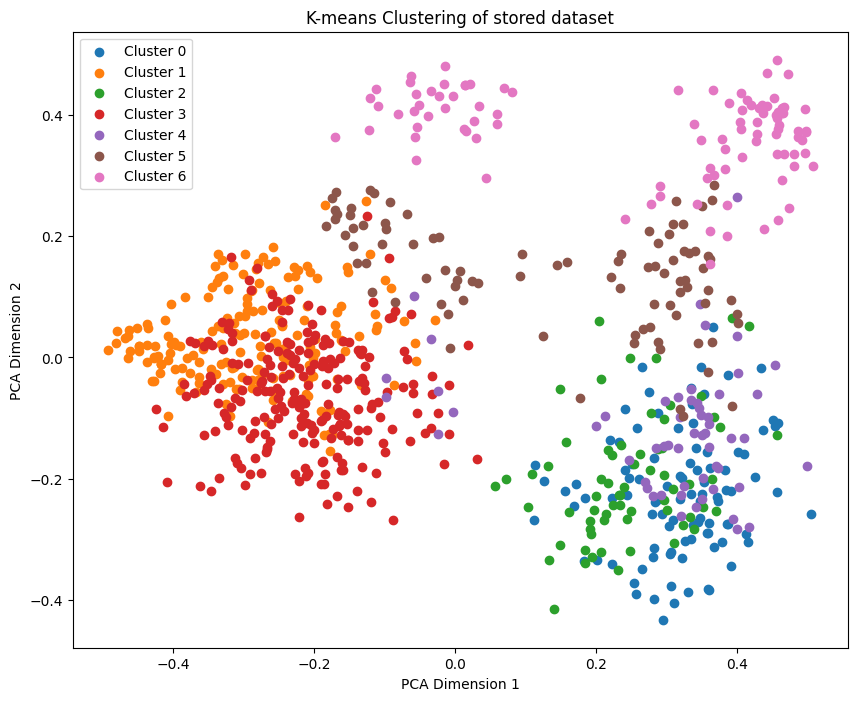


Cluster 0:
329    How many girls and boys are there in the 2022-...
330    How many girls and boys are there in the 2023-...
331    How many girls and boys are there in the 2024-...
336    Are there any plans to increase the total numb...
413    When is the "Academic Calendar" provided to st...
Name: question, dtype: object

Cluster 1:
0              Who is the founder of Sitare University?
1     What is Dr. Amit Singhal's role at Sitare Univ...
6     What motivated Dr. Amit Singhal to start Sitar...
8     Was Dr. Amit Singhal involved in any other not...
13    What does Dr. Amit Singhal aim to achieve thro...
Name: question, dtype: object

Cluster 2:
2      What was Dr. Amit Singhal's position at Google?
3    What is Dr. Amit Singhal's professional backgr...
4    Is Dr. Amit Singhal associated with philanthropy?
5                      Why is Dr. Amit Singhal famous?
7       Where can I learn more about Dr. Amit Singhal?
Name: question, dtype: object

Cluster 3:
12    How has Dr. Amit

In [25]:

# Apply K-means clustering
n_clusters = 7 # You can tune this value
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df["cluster"] = kmeans.fit_predict(embeddings)

# Analyze clusters
cluster_counts = df["cluster"].value_counts()
print("Cluster counts:\n", cluster_counts)

# Dimensionality reduction for visualization
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

# Add reduced dimensions to DataFrame
df["pca_x"] = reduced_embeddings[:, 0]
df["pca_y"] = reduced_embeddings[:, 1]

# Plot clusters
plt.figure(figsize=(10, 8))
for cluster in range(n_clusters):
    cluster_data = df[df["cluster"] == cluster]
    plt.scatter(cluster_data["pca_x"], cluster_data["pca_y"], label=f"Cluster {cluster}")

plt.title("K-means Clustering of stored dataset")
plt.xlabel("PCA Dimension 1")
plt.ylabel("PCA Dimension 2")
plt.legend()
plt.show()

# Print out the questions in each cluster
for cluster in range(n_clusters):
    print(f"\nCluster {cluster}:")
    print(df[df["cluster"] == cluster]["question"].head(5))  # Display top 5 questions in each cluster

# Save the cluster results to a CSV file
df[["id", "question", "cluster"]].to_csv("clustered_questions2.csv", index=False)
